In [1]:
# --- Imports necessários ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import joblib # Para carregar o modelo
import os # Para manipular caminhos de arquivo
import yfinance as yf # Para baixar dados históricos
#Import para tratamento de datas
from datetime import datetime, timedelta

# Filtra os warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- 1. Carregando o Modelo ---
model_dir = os.path.join('..', 'Modelos')
filename = 'modelo_google.joblib'
full_path = os.path.join(model_dir, filename)

try:
    modelo = joblib.load(full_path)
    print(f"Modelo carregado com sucesso de '{full_path}'.")
except FileNotFoundError:
    print(f"ERRO: O arquivo do modelo '{full_path}' não foi encontrado.")
    print("Por favor, verifique o caminho e certifique-se de que o modelo foi salvo corretamente.")
    print("O script não poderá continuar sem o modelo.")
    exit

Modelo carregado com sucesso de '..\Modelos\modelo_google.joblib'.


In [3]:
# --- 2. Obtenção e Preparação da Série Histórica Original (conforme seu input) ---
print("\nBaixando e preparando dados históricos do YFinance...")
goog = yf.download('GOOG',start='2015-09-21',auto_adjust=False)
print(goog.info())


Baixando e preparando dados históricos do YFinance...


[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2561 entries, 2015-09-21 to 2025-11-24
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, GOOG)  2561 non-null   float64
 1   (Close, GOOG)      2561 non-null   float64
 2   (High, GOOG)       2561 non-null   float64
 3   (Low, GOOG)        2561 non-null   float64
 4   (Open, GOOG)       2561 non-null   float64
 5   (Volume, GOOG)     2561 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.1 KB
None


In [4]:
inicio_previsao = goog.index.max() + pd.Timedelta(days=1)
final_previsao = inicio_previsao + pd.Timedelta(days=5)

In [5]:
novos_dados_index = pd.date_range(start=inicio_previsao, end=final_previsao, freq='D')
print(f"\nDatas para a previsão ({len(novos_dados_index)} dias): {novos_dados_index.strftime('%Y-%m-%d').tolist()}")


# Realizando a previsão com o modelo
# 'start' e 'end' referem-se ao intervalo do *índice* para o qual queremos previsões.
# Se novos_dados_index tem 6 elementos, queremos prever do primeiro (índice 0) ao sexto (índice 5).
previsoes_diff_log = modelo.predict(start = novos_dados_index[0],
                                     end = novos_dados_index[5],
                                     dynamic = False)

print(f"\nPrevisões do modelo (escala logarítmica e diferenciada):\n{previsoes_diff_log}")


# O último valor da transformação dos dados em log (fornecido por você)
# É CRUCIAL que este seja o último valor logarítmico DA SÉRIE USADA PARA TREINAR O MODELO
# Antes da diferenciação. Se sua_serie_original foi usada para treinar, então
# ultimo_valor_log deveria ser np.log(sua_serie_original.iloc[-1]) antes da diff.
ultimo_valor_log = 5.542204
print(f"\nÚltimo valor da série logarítmica (não-diferenciada) de treinamento (fornecido): {ultimo_valor_log}")


Datas para a previsão (6 dias): ['2025-11-25', '2025-11-26', '2025-11-27', '2025-11-28', '2025-11-29', '2025-11-30']

Previsões do modelo (escala logarítmica e diferenciada):
2025-11-25    0.000486
2025-11-26    0.000486
2025-11-27    0.000486
2025-11-28    0.000486
2025-11-29    0.000486
2025-11-30    0.000486
Freq: D, Name: predicted_mean, dtype: float64

Último valor da série logarítmica (não-diferenciada) de treinamento (fornecido): 5.542204


In [6]:
# --- 4. REVERTER AS TRANSFORMAÇÕES ---

# Reverter a Diferenciação (Inverse Differencing)
previsoes_log_revertidas = [ultimo_valor_log]

for i in range(len(previsoes_diff_log)):
    val_diff = previsoes_diff_log.iloc[i] if isinstance(previsoes_diff_log, pd.Series) else previsoes_diff_log[i]
    next_log_value = val_diff + previsoes_log_revertidas[-1]
    previsoes_log_revertidas.append(next_log_value)

previsoes_log_revertidas = np.array(previsoes_log_revertidas[1:])

print(f"\nPrevisões após reversão da diferenciação (ainda em escala logarítmica):\n{previsoes_log_revertidas}")

# Reverter a Transformação Logarítmica (Inverse Log Transformation)
previsoes_finais = np.exp(previsoes_log_revertidas)

print(f"\nPrevisões finais na escala original:\n{previsoes_finais}")


Previsões após reversão da diferenciação (ainda em escala logarítmica):
[5.54268975 5.5431755  5.54366124 5.54414699 5.54463274 5.54511849]

Previsões finais na escala original:
[255.36394124 255.48801395 255.61214694 255.73634025 255.86059389
 255.98490791]


In [7]:
# --- 5. APRESENTAR OS VALORES EM UM DATAFRAME ---
df_previsoes_finais = pd.DataFrame({
    'Data': novos_dados_index,
    'Valor Previsto': previsoes_finais
})

print("\n--- DataFrame de Previsões Finais (Valores Originais) ---")
print(df_previsoes_finais)


--- DataFrame de Previsões Finais (Valores Originais) ---
        Data  Valor Previsto
0 2025-11-25      255.363941
1 2025-11-26      255.488014
2 2025-11-27      255.612147
3 2025-11-28      255.736340
4 2025-11-29      255.860594
5 2025-11-30      255.984908


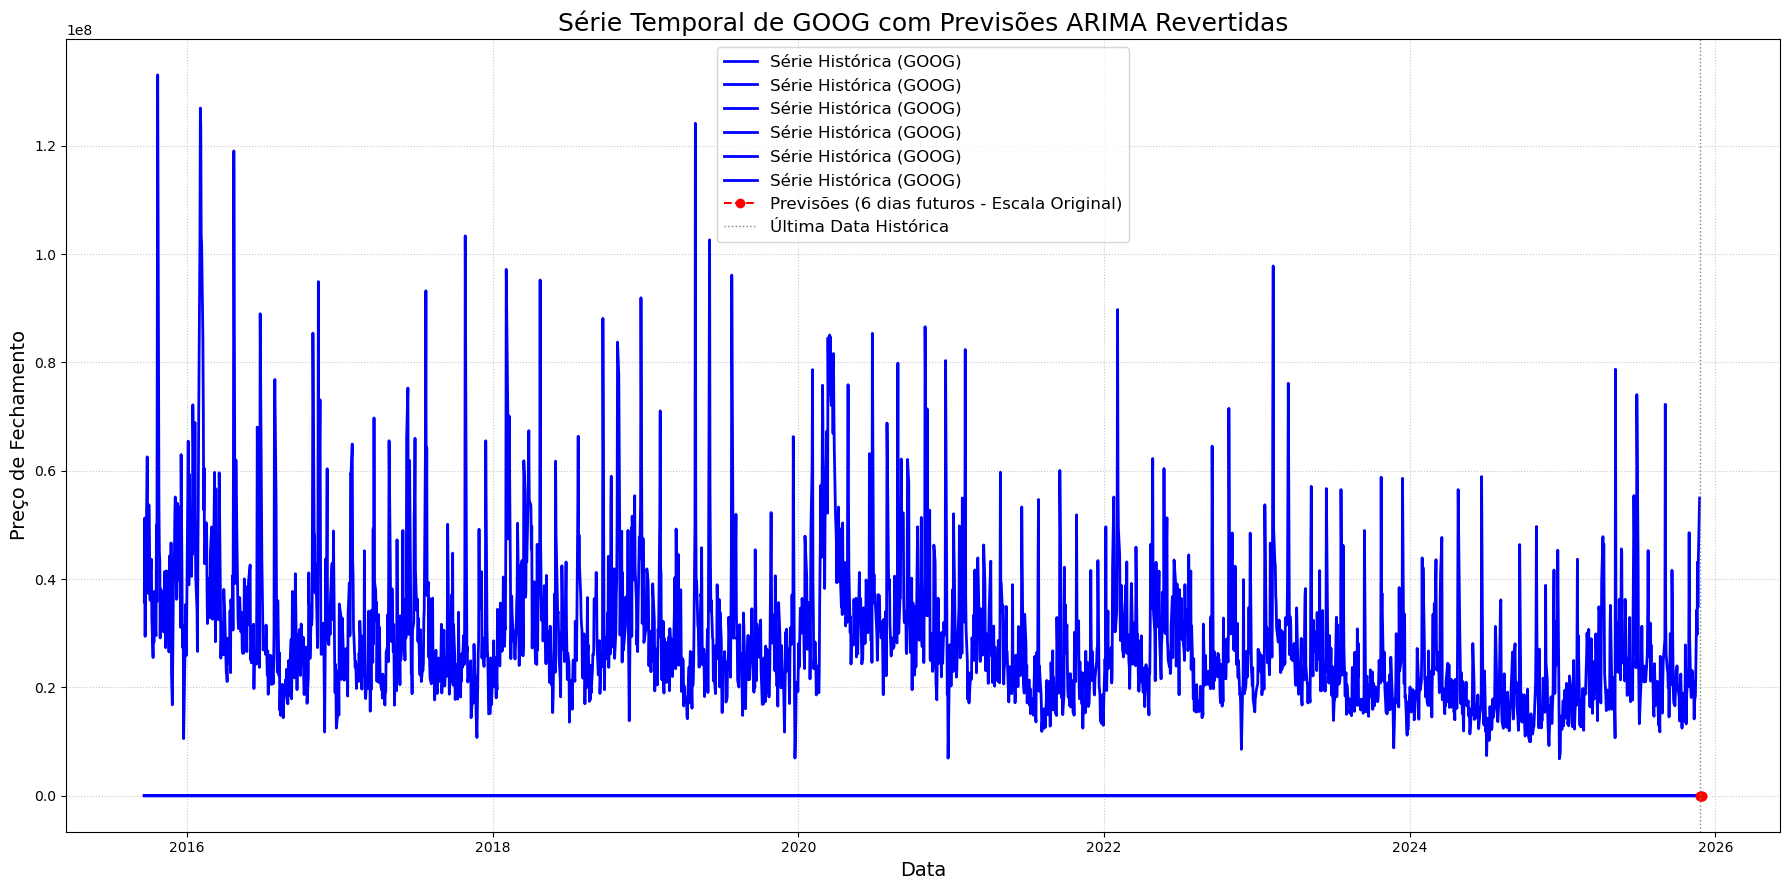

In [8]:
# --- 6. VISUALIZAÇÃO GRÁFICA ---
plt.figure(figsize=(18, 9))

# Plot da série histórica (agora usando sua_serie_original preparada)
plt.plot(goog.index, goog.values, label='Série Histórica (GOOG)', color='blue', linewidth=2)

# Plot das previsões futuras
plt.plot(df_previsoes_finais['Data'], df_previsoes_finais['Valor Previsto'],
         label=f'Previsões ({len(previsoes_finais)} dias futuros - Escala Original)',
         color='red', linestyle='--', marker='o', markersize=6)

# Linha vertical marcando o ponto de transição
plt.axvline(x=goog.index[-1], color='gray', linestyle=':', linewidth=1, label='Última Data Histórica')
# Não precisamos de uma segunda linha para 'inicio_previsao' pois ela segue imediatamente
# plt.axvline(x=inicio_previsao, color='green', linestyle=':', linewidth=1, label='Início das Previsões')


plt.title('Série Temporal de GOOG com Previsões ARIMA Revertidas', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Preço de Fechamento', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()